In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio


In [2]:
# Inicializar Gmsh
gmsh.initialize()

# Abrir archivo .geo
file = "llave.geo"
gmsh.open(file)  # <-- Esta es la clave para cargar la geometría

# Añadir nombre del modelo (opcional si ya está en el archivo)
gmsh.model.setCurrent("llave")

# Sincronizar por si quieres modificar algo en Python
gmsh.model.geo.synchronize()

# Lanzar la interfaz gráfica para visualizar
#gmsh.fltk.run()

# Finalizar Gmsh cuando termines
gmsh.finalize()


Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'


In [3]:
#Establezco el tamaño de la malla
lc = 1

# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
#gmsh.fltk.run()

gmsh.finalize()

Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Circle)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 201 (Circle)
Info    : [ 30%] Meshing curve 202 (Circle)
Info    : [ 30%] Meshing curve 203 (Line)
Info    : [ 30%] Meshing curve 204 (Line)
Info    : [ 40%] Meshing curve 205 (Circle)
Info    : [ 40%] Meshing curve 206 (Circle)
Info    : [ 50%] Meshing curve 207 (Circle)
Info    : [ 50%] Meshing curve 208 (Circle)
Info    : [ 60%] Meshing curve 301 (Line)
Info    : [ 60%] Meshing curve 302 (Line)
Info    : [ 60%] Meshing curve 303 (Circle)
Info    : [ 70%] Meshing curve 304 (Circle)
Info    : [ 70%] Meshing curve 305 (Circle)
Info    : [ 80%] Meshing curve 306 (Line)
Info    : [ 80%] Meshing curve 307 (Line)
Info    : [ 80%] Meshing curve 401 (Line)
Info    : [ 90%] Meshing curve 402 (Line)
Info

In [4]:
import meshio

# Cargar el archivo de malla .msh (versión 4.1 de Gmsh)
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")



Block 0 - Tipo: line, Cantidad: 16, Physical tags: {5}
Block 1 - Tipo: line, Cantidad: 16, Physical tags: {6}
Block 2 - Tipo: line, Cantidad: 22, Physical tags: {7}
Block 3 - Tipo: triangle, Cantidad: 980, Physical tags: {1}
Block 4 - Tipo: triangle, Cantidad: 1577, Physical tags: {2}
Block 5 - Tipo: triangle, Cantidad: 1212, Physical tags: {3}
Block 6 - Tipo: triangle, Cantidad: 1156, Physical tags: {4}



Grupo Restr Sup - Nodo 17 - Coordenadas (-55.36813052031904, 8.833833256085313)
Grupo Restr Sup - Nodo 464 - Coordenadas (-56.31687236279536, 8.517781177581227)
Grupo Restr Sup - Nodo 464 - Coordenadas (-56.31687236279536, 8.517781177581227)
Grupo Restr Sup - Nodo 465 - Coordenadas (-57.26561420527543, 8.201729099075893)
Grupo Restr Sup - Nodo 465 - Coordenadas (-57.26561420527543, 8.201729099075893)
Grupo Restr Sup - Nodo 466 - Coordenadas (-58.21435604775398, 7.885677020571062)
Grupo Restr Sup - Nodo 466 - Coordenadas (-58.21435604775398, 7.885677020571062)
Grupo Restr Sup - Nodo 467 - Coordenadas (-59.16309789023249, 7.569624942066247)
Grupo Restr Sup - Nodo 467 - Coordenadas (-59.16309789023249, 7.569624942066247)
Grupo Restr Sup - Nodo 468 - Coordenadas (-60.1118397327112, 7.253572863561364)
Grupo Restr Sup - Nodo 468 - Coordenadas (-60.1118397327112, 7.253572863561364)
Grupo Restr Sup - Nodo 469 - Coordenadas (-61.06058157518991, 6.93752078505648)
Grupo Restr Sup - Nodo 469 - Co

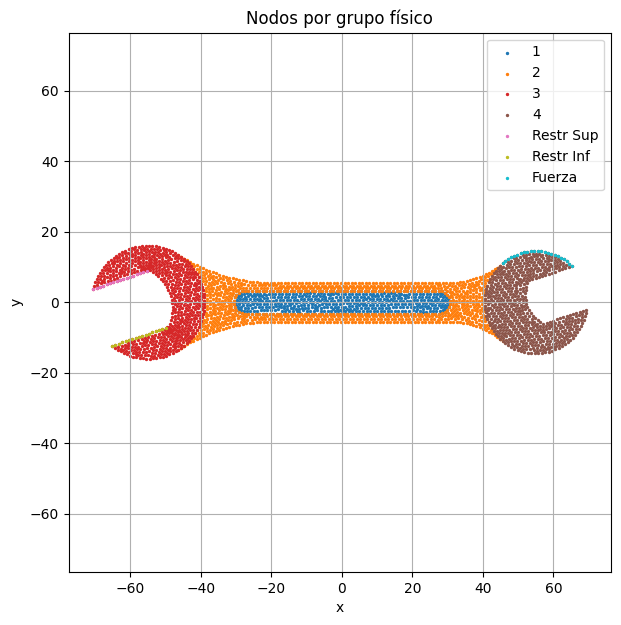

In [5]:
import meshio
from nodes import Node

# Leer archivo .msh
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}

# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, x, y))

# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = [0, 0]
            if nombre in ["Restr Sup", "Restr Inf"]:
                print(f"Grupo {nombre} - Nodo {node_id+1} - Coordenadas ({x}, {y})")
                restrain = [1, 1]
            grupos[nombre].append(Node(node_id+1, x, y, restrain=restrain))

           


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())

# Graficar por grupo
Node.plot_nodes_por_grupo(grupos, show_ids=False)


In [6]:
from section import Section

#Ahora creo las 4 secciones posibles
thicknes = {"1": 2.0, "2": 4.0, "3": 5.0, "4": 5.0}
sections = {}

#Defino las propiedades del material

E = 3000
nu = 0.37
rho = 1.25

for group in thicknes:
    sections[group] = Section(thicknes[group], E, nu)


In [7]:
#Genero un diccionario de nodos para buscarlos por id

nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node

In [8]:
from cst import CST

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []
nodes = set()  # Usamos un set para evitar nodos repetidos

for i in range(len(tags)):
    section = sections[str(tags[i])]

    node_ids = triangles[i]
    print(node_ids)
    nodo_a = nodes_dict[node_ids[0]+1]
    nodo_b = nodes_dict[node_ids[1]+1]
    nodo_c = nodes_dict[node_ids[2]+1]

    print(f"Elemento {i+1} - Sección: {section.thickness} - Nodos: {nodo_a.id}, {nodo_b.id}, {nodo_c.id}")

    for nodo in [nodo_a, nodo_b, nodo_c]:
        nodes.add(nodo)  # Se agregan al set automáticamente sin duplicados

        if np.all(nodo.restrain == [1, 1]):
            print(f"Nodo {nodo.id} con restricción total está en elemento {i+1}, coordenadaa ")
            print(f'las coordenadas son {nodo.x}, {nodo.y}')
            print('')

    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section)
    elements.append(elem)

nodes = list(nodes)



[ 40  41 802]
Elemento 1 - Sección: 2.0 - Nodos: 41, 42, 803
[616  78 831]
Elemento 2 - Sección: 2.0 - Nodos: 617, 79, 832
[868 732 882]
Elemento 3 - Sección: 2.0 - Nodos: 869, 733, 883
[732 814 882]
Elemento 4 - Sección: 2.0 - Nodos: 733, 815, 883
[696 698 821]
Elemento 5 - Sección: 2.0 - Nodos: 697, 699, 822
[801  40 802]
Elemento 6 - Sección: 2.0 - Nodos: 802, 41, 803
[ 799  144 1004]
Elemento 7 - Sección: 2.0 - Nodos: 800, 145, 1005
[906 622 961]
Elemento 8 - Sección: 2.0 - Nodos: 907, 623, 962
[ 39  40 801]
Elemento 9 - Sección: 2.0 - Nodos: 40, 41, 802
[852 105 997]
Elemento 10 - Sección: 2.0 - Nodos: 853, 106, 998
[143 144 799]
Elemento 11 - Sección: 2.0 - Nodos: 144, 145, 800
[752 750 830]
Elemento 12 - Sección: 2.0 - Nodos: 753, 751, 831
[104 105 852]
Elemento 13 - Sección: 2.0 - Nodos: 105, 106, 853
[780 599 889]
Elemento 14 - Sección: 2.0 - Nodos: 781, 600, 890
[599 780 899]
Elemento 15 - Sección: 2.0 - Nodos: 600, 781, 900
[899 780 910]
Elemento 16 - Sección: 2.0 - Nodos: 9

Nodo fijo: 17
Nodo fijo: 464
Nodo fijo: 17
Nodo fijo: 464
Nodo fijo: 18
Nodo fijo: 18
Nodo fijo: 479
Nodo fijo: 18
Nodo fijo: 479
Nodo fijo: 18
Nodo fijo: 492
Nodo fijo: 492
Nodo fijo: 464
Nodo fijo: 464
Nodo fijo: 466
Nodo fijo: 467
Nodo fijo: 466
Nodo fijo: 467
Nodo fijo: 464
Nodo fijo: 464
Nodo fijo: 466
Nodo fijo: 466
Nodo fijo: 467
Nodo fijo: 467
Nodo fijo: 493
Nodo fijo: 16
Nodo fijo: 493
Nodo fijo: 16
Nodo fijo: 478
Nodo fijo: 15
Nodo fijo: 478
Nodo fijo: 15
Nodo fijo: 475
Nodo fijo: 475
Nodo fijo: 483
Nodo fijo: 483
Nodo fijo: 481
Nodo fijo: 481
Nodo fijo: 484
Nodo fijo: 484
Nodo fijo: 482
Nodo fijo: 482
Nodo fijo: 482
Nodo fijo: 481
Nodo fijo: 482
Nodo fijo: 481
Nodo fijo: 465
Nodo fijo: 465
Nodo fijo: 464
Nodo fijo: 465
Nodo fijo: 464
Nodo fijo: 465
Nodo fijo: 491
Nodo fijo: 490
Nodo fijo: 491
Nodo fijo: 490
Nodo fijo: 488
Nodo fijo: 487
Nodo fijo: 488
Nodo fijo: 487
Nodo fijo: 485
Nodo fijo: 485
Nodo fijo: 469
Nodo fijo: 469
Nodo fijo: 476
Nodo fijo: 477
Nodo fijo: 476
Nodo 

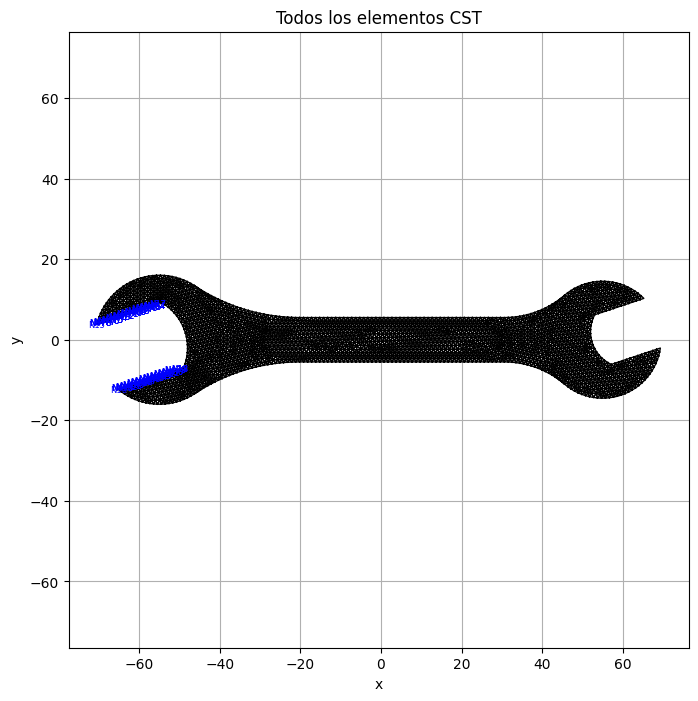

In [9]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_all_elements(elements, show_ids=True):
    """
    Dibuja todos los elementos CST en una sola figura.

    Parámetros:
    - elements: lista de instancias de CST
    - show_ids: si True, muestra los ID de los nodos y elementos
    """
    plt.figure(figsize=(8, 8))
    
    for elem in elements:
        coords = elem.get_xy_matrix()              # Coordenadas de nodos
        coords = np.vstack([coords, coords[0]])    # cerrar triángulo

        # Diagnóstico: imprimir si algún nodo está completamente restringido
        if np.array_equal(elem.node_list[0].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[0].id}")
        if np.array_equal(elem.node_list[1].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[1].id}")
        if np.array_equal(elem.node_list[2].restrain, [1, 1]):
            print(f"Nodo fijo: {elem.node_list[2].id}")



        # Dibujar contorno del triángulo
        plt.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        # Mostrar ID solo de nodos fijos (con restricción total)
        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords[:-1]):
                if np.all(nodo.restrain == [1, 1]):
                    print(f"Nodo fijo: {nodo.id}")
                    plt.text(x, y, f'N{nodo.id}', color='blue', fontsize=6, ha='center', va='center')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.title("Todos los elementos CST")
    plt.show()



plot_all_elements(elements)

In [10]:
from solve import Solve

estructure = Solve(nodes, elements)

In [11]:
# Aplicar fuerza vertical arbitraria en el grupo "Fuerza"
if "Fuerza" in grupos:
    nodos_fuerza = grupos["Fuerza"]
    Py_total = -100.0  # N negativos = hacia abajo (puedes cambiarlo)
    f_por_nodo = Py_total / len(nodos_fuerza)

    for nodo in nodos_fuerza:
        dof_y = nodo.id * 2 
        print(f"Aplicando fuerza {f_por_nodo} N en el nodo {nodo.id} (DOF {dof_y})")
        estructure.apply_force(dof_index=dof_y, value=-5000.0)  # Por ejemplo, 50 N hacia abajo

Aplicando fuerza -4.3478260869565215 N en el nodo 22 (DOF 44)
Aplicando fuerza -4.3478260869565215 N en el nodo 532 (DOF 1064)
Aplicando fuerza -4.3478260869565215 N en el nodo 533 (DOF 1066)
Aplicando fuerza -4.3478260869565215 N en el nodo 534 (DOF 1068)
Aplicando fuerza -4.3478260869565215 N en el nodo 535 (DOF 1070)
Aplicando fuerza -4.3478260869565215 N en el nodo 536 (DOF 1072)
Aplicando fuerza -4.3478260869565215 N en el nodo 537 (DOF 1074)
Aplicando fuerza -4.3478260869565215 N en el nodo 538 (DOF 1076)
Aplicando fuerza -4.3478260869565215 N en el nodo 539 (DOF 1078)
Aplicando fuerza -4.3478260869565215 N en el nodo 540 (DOF 1080)
Aplicando fuerza -4.3478260869565215 N en el nodo 541 (DOF 1082)
Aplicando fuerza -4.3478260869565215 N en el nodo 542 (DOF 1084)
Aplicando fuerza -4.3478260869565215 N en el nodo 543 (DOF 1086)
Aplicando fuerza -4.3478260869565215 N en el nodo 544 (DOF 1088)
Aplicando fuerza -4.3478260869565215 N en el nodo 545 (DOF 1090)
Aplicando fuerza -4.34782608

In [12]:
for node in nodes:
    print(f"Nodo {node.id} - Dofs {node.dofs}")

Nodo 1491 - Dofs [2981 2982]
Nodo 1492 - Dofs [2983 2984]
Nodo 1170 - Dofs [2339 2340]
Nodo 1123 - Dofs [2245 2246]
Nodo 2171 - Dofs [4341 4342]
Nodo 1578 - Dofs [3155 3156]
Nodo 2228 - Dofs [4455 4456]
Nodo 699 - Dofs [1397 1398]
Nodo 1108 - Dofs [2215 2216]
Nodo 2216 - Dofs [4431 4432]
Nodo 1409 - Dofs [2817 2818]
Nodo 1175 - Dofs [2349 2350]
Nodo 1168 - Dofs [2335 2336]
Nodo 1383 - Dofs [2765 2766]
Nodo 1569 - Dofs [3137 3138]
Nodo 1800 - Dofs [3599 3600]
Nodo 1231 - Dofs [2461 2462]
Nodo 1579 - Dofs [3157 3158]
Nodo 1803 - Dofs [3605 3606]
Nodo 698 - Dofs [1395 1396]
Nodo 1232 - Dofs [2463 2464]
Nodo 1014 - Dofs [2027 2028]
Nodo 1581 - Dofs [3161 3162]
Nodo 2404 - Dofs [4807 4808]
Nodo 697 - Dofs [1393 1394]
Nodo 1081 - Dofs [2161 2162]
Nodo 1008 - Dofs [2015 2016]
Nodo 1580 - Dofs [3159 3160]
Nodo 696 - Dofs [1391 1392]
Nodo 1057 - Dofs [2113 2114]
Nodo 1035 - Dofs [2069 2070]
Nodo 1668 - Dofs [3335 3336]
Nodo 1583 - Dofs [3165 3166]
Nodo 1916 - Dofs [3831 3832]
Nodo 2519 - Dofs [

In [13]:
zero_rows = estructure.check_zero_rows()

for row in zero_rows:
    for node in estructure.nodes:
        if row in node.dofs:
            print(f"⚠️ DOF {row} pertenece al nodo {node.id} (restrain={node.restrain})")

for node in estructure.nodes:
    if 0 in node.dofs:
        print(f"⚠️ DOF 0 pertenece al nodo {node.id}, DOFs: {node.dofs}, restrain={node.restrain}")


❌ Fila(s) completamente nulas en K_global: [   0    1    2 ... 5318 5319 5320]
⚠️ DOF 1 pertenece al nodo 1 (restrain=[0 0])
⚠️ DOF 2 pertenece al nodo 1 (restrain=[0 0])
⚠️ DOF 3 pertenece al nodo 2 (restrain=[0 0])
⚠️ DOF 4 pertenece al nodo 2 (restrain=[0 0])
⚠️ DOF 5 pertenece al nodo 3 (restrain=[0 0])
⚠️ DOF 6 pertenece al nodo 3 (restrain=[0 0])
⚠️ DOF 7 pertenece al nodo 4 (restrain=[0 0])
⚠️ DOF 8 pertenece al nodo 4 (restrain=[0 0])
⚠️ DOF 9 pertenece al nodo 5 (restrain=[0 0])
⚠️ DOF 10 pertenece al nodo 5 (restrain=[0 0])
⚠️ DOF 11 pertenece al nodo 6 (restrain=[0 0])
⚠️ DOF 12 pertenece al nodo 6 (restrain=[0 0])
⚠️ DOF 13 pertenece al nodo 7 (restrain=[0 0])
⚠️ DOF 14 pertenece al nodo 7 (restrain=[0 0])
⚠️ DOF 15 pertenece al nodo 8 (restrain=[0 0])
⚠️ DOF 16 pertenece al nodo 8 (restrain=[0 0])
⚠️ DOF 17 pertenece al nodo 9 (restrain=[0 0])
⚠️ DOF 18 pertenece al nodo 9 (restrain=[0 0])
⚠️ DOF 19 pertenece al nodo 10 (restrain=[0 0])
⚠️ DOF 20 pertenece al nodo 10 (rest

In [14]:
desplazamientos = estructure.solve()

N° de DOFs libres: 5252
N° de DOFs fijos: 68


In [15]:
for nodo in estructure.nodes:
    if np.all(nodo.restrain == [0, 0]):
        ux = estructure.u_global[nodo.dofs[0]][0]
        uy = estructure.u_global[nodo.dofs[1]][0]
        if np.isclose(ux, 0.0) and np.isclose(uy, 0.0):
            print(f"⚠️ Nodo {nodo.id} es libre pero no se mueve: u = ({ux:.2e}, {uy:.2e})")


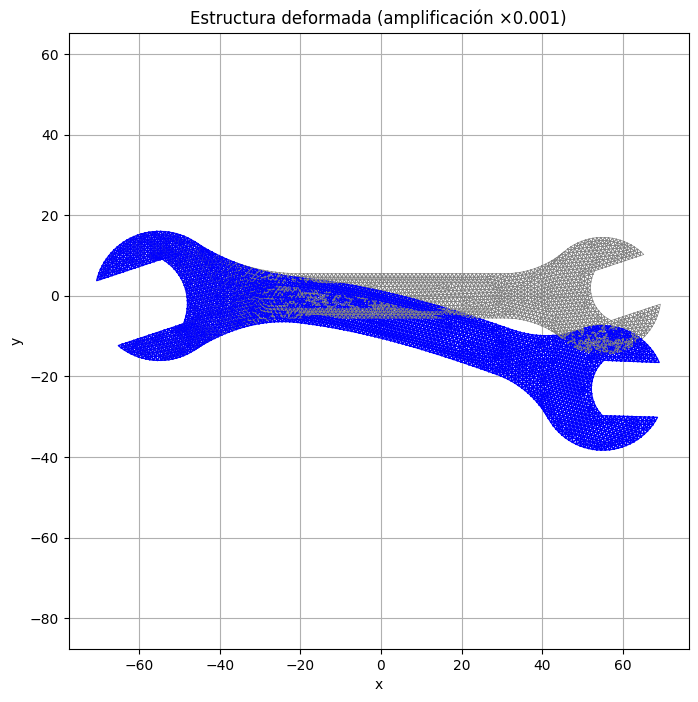

In [18]:
def plot_deformed_structure(elements, scale=1.0, show_ids=False):
    """
    Dibuja estructura original y deformada en el plano XY.

    Parámetros:
    - elements: lista de elementos (tipo CST)
    - scale: factor de amplificación de la deformación
    - show_ids: si True, muestra los IDs de los nodos
    """
    plt.figure(figsize=(8, 8))

    for elem in elements:
        coords = elem.get_xy_matrix()  # shape (3, 2) → [[x1, y1], [x2, y2], [x3, y3]]
        u = np.zeros_like(coords)

        # Obtener desplazamientos globales de cada nodo
        for i, nodo in enumerate(elem.node_list):
            ux = nodo.structure.u_global[nodo.dofs[0], 0]
            uy = nodo.structure.u_global[nodo.dofs[1], 0]
            u[i] = [ux, uy]

        # Dibujar triángulo original
        coords_closed = np.vstack([coords, coords[0]])
        plt.plot(coords_closed[:, 0], coords_closed[:, 1], 'gray', linewidth=0.5)

        # Dibujar triángulo deformado
        def_coords = coords + scale * u
        def_coords_closed = np.vstack([def_coords, def_coords[0]])
        plt.plot(def_coords_closed[:, 0], def_coords_closed[:, 1], 'b', linewidth=1.0)

        if show_ids:
            for i, nodo in enumerate(elem.node_list):
                x, y = def_coords[i]
                plt.text(x, y, str(nodo.id), fontsize=6, color='red')

    plt.title(f"Estructura deformada (amplificación ×{scale})")
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")  # Y como vertical
    plt.show()


# Importante: guardar los desplazamientos en cada nodo
for node in estructure.nodes:
    node.structure = estructure  # para acceder a u_global desde cada nodo

# Luego graficar
plot_deformed_structure(estructure.elements, scale=0.001, show_ids=False)

In [17]:
print("🔎 Nodos con desplazamiento = 0 y sin restricción:")
for nodo in estructure.nodes:
    if np.all(nodo.restrain == [0, 0]):
        ux = nodo.structure.u_global[nodo.dofs[0]]
        uy = nodo.structure.u_global[nodo.dofs[1]]
        if np.isclose(ux, 0.0) and np.isclose(uy, 0.0):
            print(f"⚠️ Nodo {nodo.id}: restrain={nodo.restrain}, u=({float(ux):.2e}, {float(uy):.2e})")



🔎 Nodos con desplazamiento = 0 y sin restricción:
